### NOTE: This notebook was originally ran using python 3.11.3

# GET EVERYTHING READY

In [60]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import warnings

# R stuff:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Set seaborn theme and context
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [61]:
# READ the data:
main_data_df = pd.read_pickle('parsed_data/main_data_df_SAMPLE2.pkl')
CT_data = pd.read_pickle('parsed_data/CT_data_SAMPLE2.pkl')
gambles = pd.read_pickle('parsed_data/gambles_SAMPLE2.pkl')

main_data_df = main_data_df.reset_index(drop=True)
CT_data = CT_data.reset_index(drop=True)
gambles = gambles.reset_index(drop=True)

# Helper functions for IPI calculations:
# -----------------------------
def extractCorrectKeyPresses(seq, presses):
    trial_key_presses = presses.copy()
    # remove key presses woth key_rt = None:
    trial_key_presses = [
        x for x in trial_key_presses if x['key_rt'] is not None]
    correct_presses = []
    min_loc_to_look = 0  # used to verify the order of the keys.
    if trial_key_presses:
        for i in range(len(seq)):
            trial_key_presses = trial_key_presses[min_loc_to_look:]
            if seq[i] in [x['key_pressed'] for x in trial_key_presses]:
                loc = [x['key_pressed']
                       for x in trial_key_presses].index(seq[i])
                correct_presses.append(trial_key_presses[loc])
                min_loc_to_look = loc + 1
    return correct_presses


def calculateIPIs(key_presses):
    ipis = np.nan
    if len(key_presses) == 3:
        IPI1 = key_presses[1]['key_rt'] - key_presses[0]['key_rt']
        IPI2 = key_presses[2]['key_rt'] - key_presses[1]['key_rt']
        ipis = [IPI1, IPI2]
    return ipis


def calc_IPI_Consistency(input_data, seperate_by_block=False):
    # cerate a copy of the data
    data = input_data.copy()
    for i in range(1, len(data)):
        row1 = data.iloc[i-1]
        row2 = data.iloc[i]
        isSameBlock = row1['block'] == row2['block']
        if row1['sub'] == row2['sub'] and row1['stimType'] == row2['stimType'] and \
                isinstance(row1['inter_press_intervals'], list) and isinstance(row2['inter_press_intervals'], list) and \
                row1['inter_press_intervals'] and row2['inter_press_intervals']:
            if not seperate_by_block or isSameBlock:
                # display(row1['inter_press_intervals'])
                # display(row2['inter_press_intervals'])
                IPI_1_abs_diff = abs(
                    row2['inter_press_intervals'][0] - row1['inter_press_intervals'][0])
                IPI_2_abs_diff = abs(
                    row2['inter_press_intervals'][1] - row1['inter_press_intervals'][1])
                # calculate the sum of the absolute difference between the IPIs:
                IPI_abs_diff_sum = IPI_1_abs_diff + IPI_2_abs_diff

                # add it to the dataframe:
                data.loc[i, 'IPI_abs_diff_sum'] = IPI_abs_diff_sum
    return data


# Create the IPI data:
# -----------------------------
IPI_consistency_data = main_data_df[main_data_df['blockType'] != 'gambles_only'].copy()

# create a new column based on SRO_keyPressSummary that includes only the correct sequence pressing (according to stim_seq)
IPI_consistency_data.loc[:, 'SRO_keyPressSummary_correct'] = IPI_consistency_data.apply(lambda row: extractCorrectKeyPresses(row['stim_seq'], row['SRO_keyPressSummary']), axis=1)
IPI_consistency_data.loc[:, 'inter_press_intervals'] = IPI_consistency_data.apply(lambda row: calculateIPIs(row['SRO_keyPressSummary_correct']), axis=1)

# Create a new dataframes with the IPIs (with and without block seperation)
sorted_IPI_consistency_data = IPI_consistency_data.sort_values(by=['sub', 'stimType', 'block', 'trial'])
sorted_IPI_consistency_data = sorted_IPI_consistency_data.reset_index(drop=True)

# add absolute stimulus trial number:
sorted_IPI_consistency_data.loc[:, 'stim_abs_trial'] = sorted_IPI_consistency_data.groupby(['sub', 'stimType']).cumcount() + 1

IPI_consistency_data_by_trial = calc_IPI_Consistency(sorted_IPI_consistency_data, seperate_by_block=False)
IPI_consistency_data_w_block_sep = calc_IPI_Consistency(sorted_IPI_consistency_data, seperate_by_block=True)

# add time befroe/after (deval) to main_data_df:
# -----------------------------------------------
main_data_df['time'] = np.nan
main_data_df.loc[main_data_df['phase'] == 'pre_test', 'time'] = 'before'
main_data_df.loc[main_data_df['phase'] == 'test', 'time'] = 'after'
main_data_df.loc[main_data_df['phase'] == 'reacquisition', 'time'] = 'after'
main_data_df.loc[:, ['sub', 'phase', 'time']].tail(100)

main_data_df = main_data_df.reset_index(drop=True)


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/2627051751.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'before' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  main_data_df.loc[main_data_df['phase'] == 'pre_test', 'time'] = 'before'


# FUNCTIONS

In [62]:
def prepare_local_std(data, var_of_comparison=None, var = None, smoothing_window=5):
    # remove'_std' from the var name:
    var = var.split('_local_std')[0]
    data = data.copy()
    # remove reward type rock:
    data = data[data['rewardType'] != 'rock']

    # smooth the data:
    if var_of_comparison is not None:
        data.loc[:, var + '_local_std'] = data.groupby(['sub', 'stim_condition'])[var].transform(lambda x: x.rolling(smoothing_window).std())
    else:
        data.loc[:, var + '_local_std'] = data.groupby(['sub'])[var].transform(lambda x: x.rolling(smoothing_window).std())
    
    # remove nan values:
    data = data[data[var + '_local_std'].notna()].reset_index(drop=True)

    data.loc[:, 'stim_abs_trial'] = data.groupby(['sub', 'stimType']).cumcount()
    return data


def plotTimeVarGroups(data, var_of_interest='SRO_seq_completion_time', time_var='block', var_of_comparison='rewardType', include_never_valued=False, hue_order=['blue', 'red'], pallette=['blue', 'red'], statistic='mean', include_test_pahse=True, y_label=None):
    if time_var == 'phase':
        data.loc[:, time_var] = pd.Categorical(data[time_var], categories=[
                                               'pre_test', 'test', 'reacquisition'], ordered=True)

    # get only trials with a reward type blue or red:
    if include_never_valued:
        relevant_data = data[data['rewardType'].isin(['blue', 'red', 'rock'])]
    else:
        relevant_data = data[data['rewardType'].isin(['blue', 'red'])]
    # remove trials with seq completion, i.e. there is no nan in the var_of_interest column:
    relevant_data = relevant_data[~relevant_data[var_of_interest].isna()].reset_index(drop=True)
    if not include_test_pahse:
        relevant_data = relevant_data[relevant_data['phase'] != 'test']
        relevant_data = relevant_data[relevant_data['phase'] != 'reacquisition'].reset_index(drop=True)
    # calclulate the relevant measure:
    if statistic == 'mean':
        if var_of_comparison is None:
            # if var_of_comparison is None, then we want to calculate the mean for each sub and block:
            relevant_data_summary = relevant_data.groupby(
                ['group', 'sub', time_var])[var_of_interest].mean()
        else:
            # calculate the average seq completion time per sub prer block per reward type:
            relevant_data_summary = relevant_data.groupby(
                ['group', 'sub', time_var, var_of_comparison])[var_of_interest].mean()
    elif statistic == 'STD':
        if var_of_comparison is None:
            # if var_of_comparison is None, then we want to calculate the std for each sub and block:
            relevant_data_summary = relevant_data.groupby(
                ['group', 'sub', time_var])[var_of_interest].std()
        else:
            # calculate the variance of seq completion time per sub prer block per reward type:
            relevant_data_summary = relevant_data.groupby(
                ['group', 'sub', time_var, var_of_comparison])[var_of_interest].std()

    relevant_data_summary = relevant_data_summary.reset_index()

    # Separate the data for the "moderate" group
    moderate_group = relevant_data_summary[relevant_data_summary['group'] == 'extensive']
    blockNumbers_moderate = moderate_group[time_var].unique()
    x_ticks_loc_moderate = [x for x in range(len(blockNumbers_moderate))]
    moderate_group.loc[:, time_var] = moderate_group[time_var].replace(
        blockNumbers_moderate, x_ticks_loc_moderate)
    
    relevant_data_summary.loc[:, time_var] = relevant_data_summary[time_var].replace(
        blockNumbers_moderate, x_ticks_loc_moderate)

    if var_of_comparison is not None:

        # Plotting
        # -----------------------------
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

        # Plot for the "moderate" group
        sns.lineplot(data=moderate_group, x=time_var, y=var_of_interest, hue=var_of_comparison,
                    hue_order=hue_order, palette=pallette, ax=axes[0], legend=False, errorbar=('se', 1))
        sns.lineplot(data=moderate_group, x=time_var, y=var_of_interest, hue=var_of_comparison, hue_order=hue_order,
                    style='sub', markers=True, dashes=False, alpha=0.01, legend=False, palette=pallette, ax=axes[0])
        axes[0].set_title('Sample 2 (moderate training)')
        axes[0].set_xlabel(time_var)
        if y_label is not None:
            axes[0].set_ylabel(y_label)
        else:
            axes[0].set_ylabel(f'{statistic} {var_of_interest}')
        axes[0].set_xticks(x_ticks_loc_moderate)
        axes[0].set_xticklabels(blockNumbers_moderate)

    else:
        label_map = {
            'extensive': 'Sample 2 (moderate training)',
            }
        plot_df = relevant_data_summary.copy()
        plot_df['group'] = plot_df['group'].map(label_map)
        group_palette = {
            'Sample 2 (moderate training)': 'green',
        }

        # Plotting without var_of_comparison
        # -----------------------------
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        sns.lineplot(data=plot_df, x=time_var, y=var_of_interest,
                    hue='group', palette=group_palette, ax=axes, errorbar='se', hue_order = ['Sample 2 (moderate training)'])

        axes.set_xlabel('Block')
        if y_label is not None:
            axes.set_ylabel(y_label)
        else:
            axes.set_ylabel(f'{statistic} {var_of_interest}')
        axes.set_xticks(x_ticks_loc_moderate)
        axes.set_xticklabels(blockNumbers_moderate)
        legend = axes.legend()

    # plt.tight_layout()
    plt.show()


# fit an exponential decay to the data:
# -------------------------------------------
def exponential_decay(x, asymp_to, improvement, alpha):
    return asymp_to + improvement * np.exp(-alpha * x)


# PRE-REGISTERED EXCLUSIONS

## Get exclusions

In [63]:
PRE_REG_EXCLUSIONS = {}

# get the number of n_pressing_gambleKeys_in_SRO as a table:
n_pressing_gambleKeys_in_SRO_summary = main_data_df.groupby(['group', 'sub', 'block'])['n_pressing_gambleKeys_in_SRO'].sum()
n_pressing_gambleKeys_in_SRO_summary = n_pressing_gambleKeys_in_SRO_summary.reset_index()
# make block values columns:
n_pressing_gambleKeys_in_SRO_summary_table = n_pressing_gambleKeys_in_SRO_summary.pivot(index='sub', columns='block', values='n_pressing_gambleKeys_in_SRO')
PRE_REG_EXCLUSIONS['has_a_block_with_more_than_50_gamble_key_presses_during_SRO'] = sorted(n_pressing_gambleKeys_in_SRO_summary.loc[n_pressing_gambleKeys_in_SRO_summary['n_pressing_gambleKeys_in_SRO'] > 50, 'sub'].unique().tolist())

# get the number of trials with at least one pressing of gamble keys:
trial_prop_w_gambleKeys_in_SRO = main_data_df.groupby(['group', 'sub', 'block'])['n_pressing_gambleKeys_in_SRO'].apply(lambda x: ((x > 0).sum() / len(x)).round(2)).reset_index()
# make block values columns:
trial_prop_w_gambleKeys_in_SRO_table = trial_prop_w_gambleKeys_in_SRO.pivot(index='sub', columns='block', values='n_pressing_gambleKeys_in_SRO')
PRE_REG_EXCLUSIONS['has_an_SRO_block_with_at_more_than_50_percent_trials_with_gamble_key_presses'] = sorted(trial_prop_w_gambleKeys_in_SRO.loc[trial_prop_w_gambleKeys_in_SRO['n_pressing_gambleKeys_in_SRO'] > 0.5, 'sub'].unique().tolist())
                   
# get the number of times 'choice_rt' is smaller than 200, per sub per block:
n_fast_choice_rt_summary = main_data_df.groupby(['group', 'sub', 'block'])['choice_rt'].apply(lambda x: ((x <= 200).sum() / len(x)).round(2))
n_fast_choice_rt_summary = n_fast_choice_rt_summary.reset_index()
# make block values columns:
n_fast_choice_rt_summary_table = n_fast_choice_rt_summary.pivot(index='sub', columns='block', values='choice_rt')
PRE_REG_EXCLUSIONS['has_amore_than_50_percent_gamble_trials_with_RT_less_than_200ms'] = sorted(n_fast_choice_rt_summary.loc[n_fast_choice_rt_summary['choice_rt'] > 0.5, 'sub'].unique().tolist())

# Get low SRO (Stimulus-Response-Outcome, i.e., operant learning part) engagement:
relev_SRO_data = main_data_df.loc[(main_data_df.stimType == 'planet_red') | (main_data_df.stimType == 'planet_blue'),:].copy().reset_index(drop=True)
# remove phase 'test' and 'reacquisition' (2nd test block):
relev_SRO_data = relev_SRO_data.loc[(relev_SRO_data.phase != 'test') & (relev_SRO_data.phase != 'reacquisition'),:].copy().reset_index(drop=True)
# Now for each sub, block, and group, calculate the proportion of SRO trials with sequenceCompleted:
SRO_response_rate = relev_SRO_data.groupby(['group', 'sub'])['sequenceCompleted'].apply(lambda x: (x.sum() / len(x)).round(2)).reset_index()
PRE_REG_EXCLUSIONS['has_less_than_60percent_Relevant_SRO_trials_with_sequenceCompleted'] = sorted(SRO_response_rate.loc[SRO_response_rate.sequenceCompleted < 0.6, 'sub'].unique().tolist())

# Get engagement toward the (never valued) YELLOW SRO trials:
relev_YELLOW_SRO_data = main_data_df.loc[main_data_df.stimType == 'planet_yellow',:].copy().reset_index(drop=True)
# Now for each sub, block, and group, calculate the proportion of SRO trials with sequenceCompleted:
SRO_YELLOW_response_rate = relev_YELLOW_SRO_data.groupby(['group', 'sub'])['sequenceCompleted'].apply(lambda x: (x.sum() / len(x)).round(2)).reset_index()
PRE_REG_EXCLUSIONS['has_more_than_40percent_Relevant_YELLOW_SRO_trials_with_sequenceCompleted'] = sorted(SRO_YELLOW_response_rate.loc[SRO_YELLOW_response_rate.sequenceCompleted > 0.4, 'sub'].unique().tolist())

# Get low response rate in gamble trials:
relev_gamble_data = main_data_df.loc[main_data_df.blockType != 'SRO_only',:].copy().reset_index(drop=True)
# Now for each sub, and group, calculate the proportion of SRO trials with sequenceCompleted:
Gamble_response_rate = relev_gamble_data.groupby(['group', 'sub'])['choice_rt'].apply(lambda x: (x.notnull().sum() / len(x)).round(2)).reset_index()
PRE_REG_EXCLUSIONS['has_less_than_60percent_Relevant_Gamble_trials_with_choice_rt'] = sorted(Gamble_response_rate.loc[Gamble_response_rate.choice_rt < 0.6, 'sub'].unique().tolist())


In [64]:
# now combine everything in PRE_REG_EXCLUSIONS to one list (ubique subjects) and sorted:
PRE_REG_EXCLUSIONS_LIST = sorted(set([item for sublist in PRE_REG_EXCLUSIONS.values() for item in sublist]))
print('Exlusions:', PRE_REG_EXCLUSIONS_LIST)
print('n_excluded:', len(PRE_REG_EXCLUSIONS_LIST))

# * Note on 5007: was timed out. from block 1 to 5 more than 2 hours had passed.
print('Adding 5007 to the exclusions list as he was *timed out* (took a long break in the middle of the task).')
PRE_REG_EXCLUSIONS_LIST = PRE_REG_EXCLUSIONS_LIST + [5007]
PRE_REG_EXCLUSIONS_LIST = sorted(PRE_REG_EXCLUSIONS_LIST)
print('Exlusions:', PRE_REG_EXCLUSIONS_LIST)
print('n_excluded:', len(PRE_REG_EXCLUSIONS_LIST))

# Use PRE_REG_EXCLUSIONS to print exclusion reasons:
print('\n\nExclusion reasons:')
for reason, subs in PRE_REG_EXCLUSIONS.items():
    if len(subs) > 0:
        print(f"{reason}: {', '.join(map(str, subs))} ({len(subs)} subjects)")

# Now per subject print all the reasons for exclusion:
print('\n\nExclusion reasons per subject:')
for sub in PRE_REG_EXCLUSIONS_LIST:
    reasons = []
    for reason, subs in PRE_REG_EXCLUSIONS.items():
        if sub in subs:
            reasons.append(reason)
    if len(reasons) > 0:
        print(f"Sub {sub}: {', '.join(reasons)} ({len(reasons)} reasons)")

Exlusions: [5006, 5008, 5017, 5035, 5043, 5060, 5067, 5069, 5085, 5087, 5092, 5093, 5094, 5096, 5103, 5129, 5134, 5138, 5140, 5149, 5161, 5164, 5166, 5169, 5181, 5188, 5192, 5203, 5208, 5216, 5217, 5218, 5238, 5240, 5245, 5251, 5252, 5262, 5268, 5272, 5275, 5280, 5294]
n_excluded: 43
Adding 5007 to the exclusions list as he was *timed out* (took a long break in the middle of the task).
Exlusions: [5006, 5007, 5008, 5017, 5035, 5043, 5060, 5067, 5069, 5085, 5087, 5092, 5093, 5094, 5096, 5103, 5129, 5134, 5138, 5140, 5149, 5161, 5164, 5166, 5169, 5181, 5188, 5192, 5203, 5208, 5216, 5217, 5218, 5238, 5240, 5245, 5251, 5252, 5262, 5268, 5272, 5275, 5280, 5294]
n_excluded: 44


Exclusion reasons:
has_a_block_with_more_than_50_gamble_key_presses_during_SRO: 5035, 5043, 5087, 5096, 5129, 5140, 5161, 5169, 5208, 5216, 5217, 5238, 5245, 5262, 5268, 5280, 5294 (17 subjects)
has_an_SRO_block_with_at_more_than_50_percent_trials_with_gamble_key_presses: 5006, 5008, 5035, 5043, 5085, 5087, 5092, 509

## Apply exclusion

In [65]:
print(PRE_REG_EXCLUSIONS_LIST)
# apply exclusions according to Exclusions variable:
main_data_df = main_data_df[~main_data_df['sub'].isin(PRE_REG_EXCLUSIONS_LIST)]
CT_data = CT_data[~CT_data['sub'].isin(PRE_REG_EXCLUSIONS_LIST)]
gambles = gambles[~gambles['sub'].isin(PRE_REG_EXCLUSIONS_LIST)]
IPI_consistency_data_by_trial = IPI_consistency_data_by_trial[~IPI_consistency_data_by_trial['sub'].isin(PRE_REG_EXCLUSIONS_LIST)]

main_data_df = main_data_df.reset_index(drop=True)
CT_data = CT_data.reset_index(drop=True)
gambles = gambles.reset_index(drop=True)
IPI_consistency_data_by_trial = IPI_consistency_data_by_trial.reset_index(drop=True)


[5006, 5007, 5008, 5017, 5035, 5043, 5060, 5067, 5069, 5085, 5087, 5092, 5093, 5094, 5096, 5103, 5129, 5134, 5138, 5140, 5149, 5161, 5164, 5166, 5169, 5181, 5188, 5192, 5203, 5208, 5216, 5217, 5218, 5238, 5240, 5245, 5251, 5252, 5262, 5268, 5272, 5275, 5280, 5294]


In [66]:
main_data_df['sub'].unique().shape

(258,)

## Remove phase 'shorter_time_test' (block 14)

In [67]:
main_data_df = main_data_df[main_data_df['phase'] != 'shorter_time_test'].reset_index(drop=True)
gambles = gambles[gambles['phase'] != 'shorter_time_test'].reset_index(drop=True)
IPI_consistency_data_by_trial = IPI_consistency_data_by_trial[IPI_consistency_data_by_trial['phase'] != 'shorter_time_test'].reset_index(drop=True)


# ANALYSIS


## ==========================================
## Learning and engagement across trainig (Fig S1)
## ==========================================


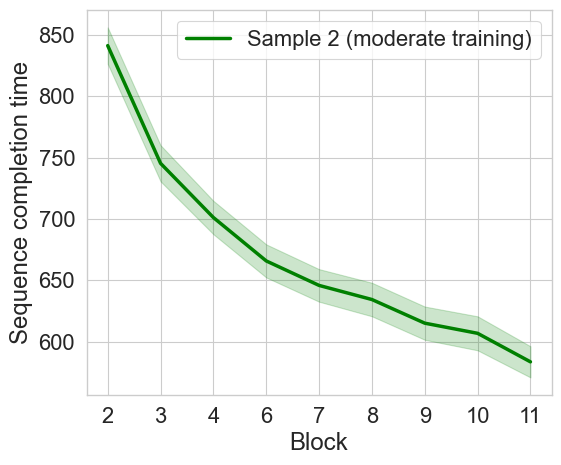

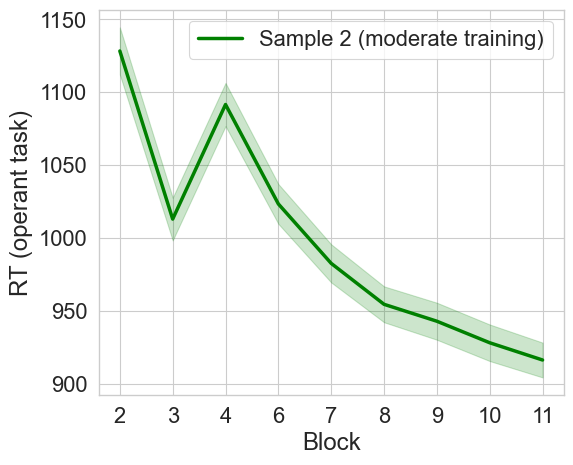

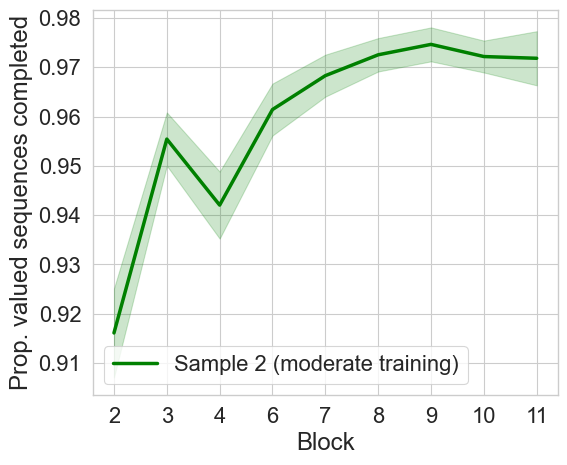

In [68]:
plotTimeVarGroups(main_data_df, var_of_interest='SRO_seq_completion_time', time_var = 'block', var_of_comparison = None, include_never_valued=False, y_label = 'Sequence completion time', include_test_pahse=False)
plotTimeVarGroups(main_data_df, var_of_interest='SRO_rt_of_SRO_key', time_var = 'block', var_of_comparison = None, include_never_valued=False, y_label = 'RT (operant task)', include_test_pahse=False)
plotTimeVarGroups(main_data_df, var_of_interest='sequenceCompleted', time_var = 'block', var_of_comparison = None, include_never_valued=False, y_label = 'Prop. valued sequences completed', include_test_pahse=False)

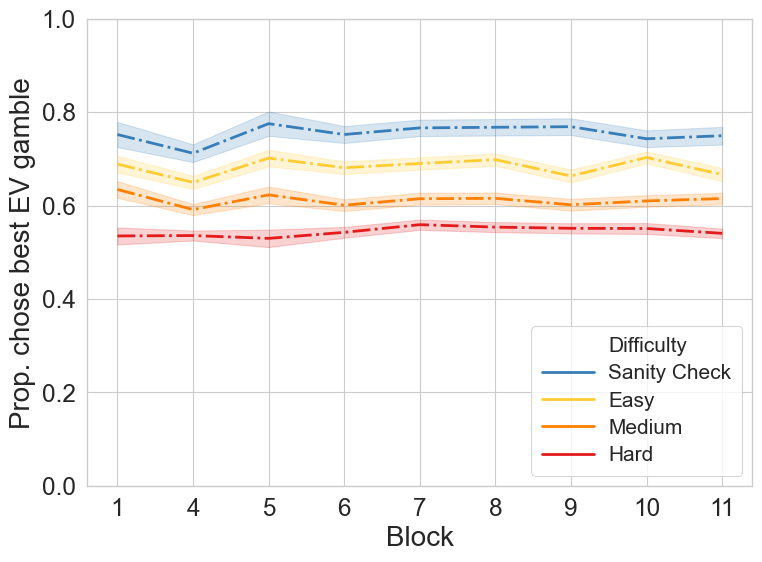

In [69]:
# Filter the data to only include pre_test phase and remove blocks 2 and 3 (SRO only blocks)
rg_filtered = gambles[(gambles['phase'] != 'test') & (gambles['phase'] != 'reacquisition')].copy()
regular_gambles_summary = (
    rg_filtered.groupby(['sub', 'block', 'gamble_type'])['chose_best_EV']
    .mean()
    .reset_index()
)

# Set a larger font size for plotting (for a paper)
sns.set_context("paper", font_scale=2)

# Custom palette with updated colors
difficulty_palette = {
    'sanityCheck': '#377eb8',   # Blue
    'easy': '#ffcc33',          # Yellow-Orange
    'medium': '#ff7f00',        # Orange
    'hard': '#e41a1c'           # Red
}

# Create a figure with two subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


# Get all unique blocks in sorted order
all_blocks = sorted(set(regular_gambles_summary['block']))

# Convert block to string
regular_gambles_summary['block'] = regular_gambles_summary['block'].astype(str)
block_order = sorted(regular_gambles_summary['block'].unique(), key=int)

sns.lineplot(
    data=regular_gambles_summary,
    x='block',
    y='chose_best_EV',
    hue='gamble_type',
    hue_order=['sanityCheck', 'easy', 'medium', 'hard'],
    ax=ax,
    errorbar=('se', 1),
    palette=difficulty_palette,
    legend=False,
    linewidth=2,
    linestyle='-.'
)

ax.set_xticks(block_order)
ax.set_xticklabels(block_order)

ax.set_xlabel('Block', fontsize=20)
ax.set_ylabel('Prop. chose best EV gamble', fontsize=20)
ax.set(ylim=(0, 1))

difficulty_handles = [
    Line2D([0], [0], color=difficulty_palette['sanityCheck'], lw=2, label='Sanity Check'),
    Line2D([0], [0], color=difficulty_palette['easy'], lw=2, label='Easy'),
    Line2D([0], [0], color=difficulty_palette['medium'], lw=2, label='Medium'),
    Line2D([0], [0], color=difficulty_palette['hard'], lw=2, label='Hard'),
]

# Define handles for group (line style)
group_handles = [
    Line2D([0], [0], color='k', lw=2, linestyle='-', label='Sample 2 (moderate training)'),
]

# Combine with section titles (as dummy handles)
legend_handles = [
    Line2D([0], [0], color='w', label='Difficulty', linewidth=0),  # Section title
    *difficulty_handles,
]

# Create the legend
ax.legend(
    handles=legend_handles,
    loc='lower right',
    frameon=True,
    fontsize=15,
    title_fontsize=15,
    handlelength=2.5,
    borderpad=0.5,      
    handletextpad=0.7,   
    labelspacing=0.4,     
    borderaxespad=0.5    
)
plt.tight_layout()
plt.show()


## ==========================================
## Effects of trainig duration on outcome devaluation + consumption test (Fig 3 equivalent)
## ==========================================


### Consumption test

In [70]:
CT_data
plot_df = CT_data.copy()
plot_df.loc[plot_df.manipulation.isna(),'manipulation'] = 'Before'
plot_df.loc[plot_df.manipulation=='devaluation','manipulation'] = 'After'
plot_df.rename(columns={'manipulation': 'Devaluation'}, inplace=True)

# For each subject, get their manipulation_stim from the 'After' row
stim_map = plot_df[plot_df['Devaluation'] == 'After'].set_index('sub')['manipulation_stim'].to_dict()
plot_df['manipulation_stim'] = plot_df.apply(
    lambda row: stim_map.get(row['sub']) if pd.isna(row['manipulation_stim']) else row['manipulation_stim'],
    axis=1
)
# create a new column called devalued where it takes the value under the column blue or red according to manipulation_stim:
plot_df['Devalued'] = plot_df.apply(
    lambda row: row['blue'] if row['manipulation_stim'] == 'blue' else row['red'] if row['manipulation_stim'] == 'red' else None,
    axis=1
)
plot_df['Valued'] = plot_df.apply(
    lambda row: row['red'] if row['manipulation_stim'] == 'blue' else row['blue'] if row['manipulation_stim'] == 'red' else None,
    axis=1
)

plot_df = plot_df[['sub', 'Devaluation', 'Devalued', 'Valued']].copy()

# Have Devalued and Valued as combined to one column with them as a condition column:
plot_df = pd.melt(plot_df, id_vars=['sub', 'Devaluation'], 
                  value_vars=['Devalued', 'Valued'],
                  var_name='Condition', value_name='Gems_collected')

plot_df['Devaluation'] = pd.Categorical(plot_df['Devaluation'], categories=['Before', 'After'], ordered=True)
plot_df['Condition'] = pd.Categorical(plot_df['Condition'], categories=['Valued', 'Devalued'], ordered=True)
plot_df.sort_values(by=['sub', 'Devaluation', 'Condition'], inplace=True)
plot_df.reset_index(drop=True, inplace=True)


#### Fig S2B

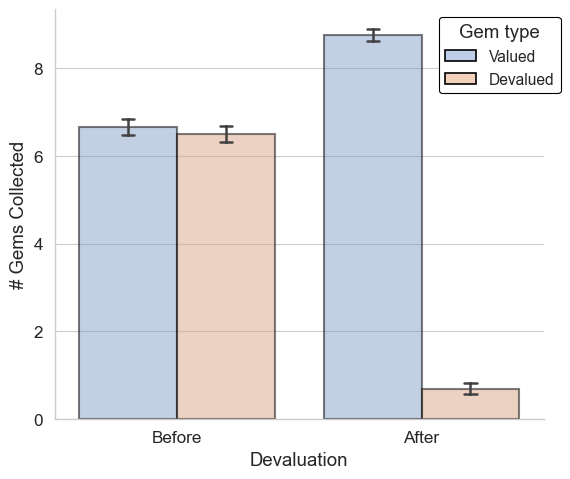

In [71]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.4)

# Define fill colors (with alpha applied in patch manually)
fill_palette = {
    'Valued': 'green',
    'Devalued': 'red',
}
fill_palette = {
    'Valued': '#7e9ed2',
    'Devalued': '#e6a37a'
}


alpha = 0.5  # for consistent transparency

# Create the grouped bar plot
g = sns.catplot(
    data=plot_df,
    x='Devaluation',
    y='Gems_collected',
    hue='Condition',
    kind='bar',
    palette=fill_palette,
    errorbar='se',
    alpha=alpha,
    height=5,
    aspect=0.9,
    sharey=True,
    capsize=0.1

)

g.set_axis_labels("Devaluation", "# Gems Collected")
title_map = {
    'Short training': 'Short training',
    'Extensive training': 'Extensive training'
}
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(title_map.get(title, title), weight='bold')

for ax in g.axes.flat:
    for container in ax.containers:
        for bar in container:
            bar.set_edgecolor("black")
            bar.set_linewidth(1.5)
            # Ensure facecolor alpha remains consistent
            fc = bar.get_facecolor()
            bar.set_facecolor((fc[0], fc[1], fc[2], alpha))

g._legend.remove()

# Custom legend with alpha and black edges
handles = [
    mpatches.Patch(
        facecolor=(*sns.color_palette([fill_palette['Valued']])[0], alpha),  # RGBA for red
        # facecolor=(0.545, 0.757, 0.486, 0.6),  # RGBA for green
        edgecolor='black',
        label='Valued',
        linewidth=1.2
    ),
    mpatches.Patch(
        facecolor=(*sns.color_palette([fill_palette['Devalued']])[0], alpha),  # RGBA for green
        # facecolor=(0.945, 0.486, 0.486, 0.6),  # RGBA for red
        edgecolor='black',
        label='Devalued',
        linewidth=1.2
    )
]

# Add new legend to top-right of left subplot
g.axes[0][0].legend(
    handles=handles,
    title="Gem type",
    loc='upper right',
    bbox_to_anchor=(1.05, 1),  # x=1.25 pushes it to the right
    frameon=True,
    framealpha=1,
    edgecolor='black',
    fontsize='small',         # reduce legend text
    title_fontsize='medium'   # adjust title size
)

plt.tight_layout()
plt.show()


#### Fig. S2C

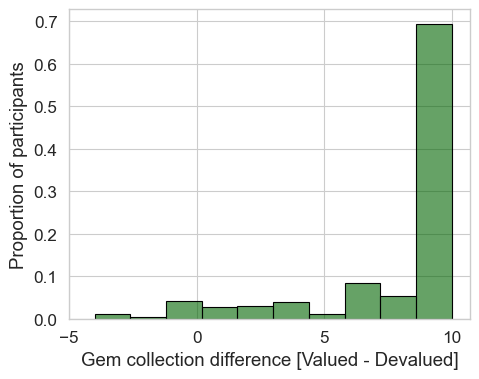

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Transparency level used in the bars
alpha_val = 0.6

group_palette = {
    'extensive': 'darkgreen',
}

# Manual legend handles with alpha applied
handles = [
    mpatches.Patch(color='darkgreen', alpha=alpha_val, label='Moderate training'),
]

# Plot
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.4)

ax = sns.histplot(
    data=CT_data,
    hue='group',
    x='non_manip_minus_manip',
    palette=group_palette,
    stat='probability',
    common_norm=False,
    multiple='layer',
    alpha=alpha_val,
    edgecolor='black',
    legend=False,
    bins=10,
)
ax.set_xticks([-5, 0, 5, 10])

ax.set_xlabel('Gem collection difference [Valued - Devalued]')
ax.set_ylabel('Proportion of participants')

plt.tight_layout()
plt.show()


In [73]:
CT_data_for_stats = CT_data.copy()
# keep only row with manipulation = devaluation:
CT_data_for_stats = CT_data_for_stats[CT_data_for_stats['manipulation'] == 'devaluation'].reset_index(drop=True)
CT_data_for_stats

,sub,group,block,trial,manipulation_stim,manipulation,blue,red,ice,rock,misses,non_manip_minus_manip
0,5001,extensive,11,33,blue,devaluation,0,10,5,0,0,10.0
1,5002,extensive,11,33,red,devaluation,10,0,0,0,1,10.0
2,5003,extensive,11,33,blue,devaluation,0,10,4,0,0,10.0
3,5004,extensive,11,33,blue,devaluation,0,9,3,0,1,9.0
4,5005,extensive,11,33,red,devaluation,9,0,1,0,1,9.0
5,5009,extensive,11,33,red,devaluation,10,0,0,0,0,10.0
6,5010,extensive,11,33,blue,devaluation,0,10,0,0,0,10.0
7,5011,extensive,11,33,red,devaluation,2,0,6,0,0,2.0
8,5012,extensive,11,33,blue,devaluation,2,10,10,0,4,8.0
9,5013,extensive,11,33,blue,devaluation,0,10,1,0,0,10.0


#### stats

In [74]:
%%R -i CT_data_for_stats
library(lme4)

# run lm:
lm_model <- lm(non_manip_minus_manip ~ 1, data = CT_data_for_stats)
summary(lm_model)


Call:
lm(formula = non_manip_minus_manip ~ 1, data = CT_data_for_stats)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.0698  -0.8198   1.9302   1.9302   1.9302 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   8.0698     0.2038    39.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.273 on 257 degrees of freedom



### Devaluation Summary - Main (sensitivity to outcome value)

#### Devalued Sequence Completion (Fig. 2F)

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/1997838531.py:55: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


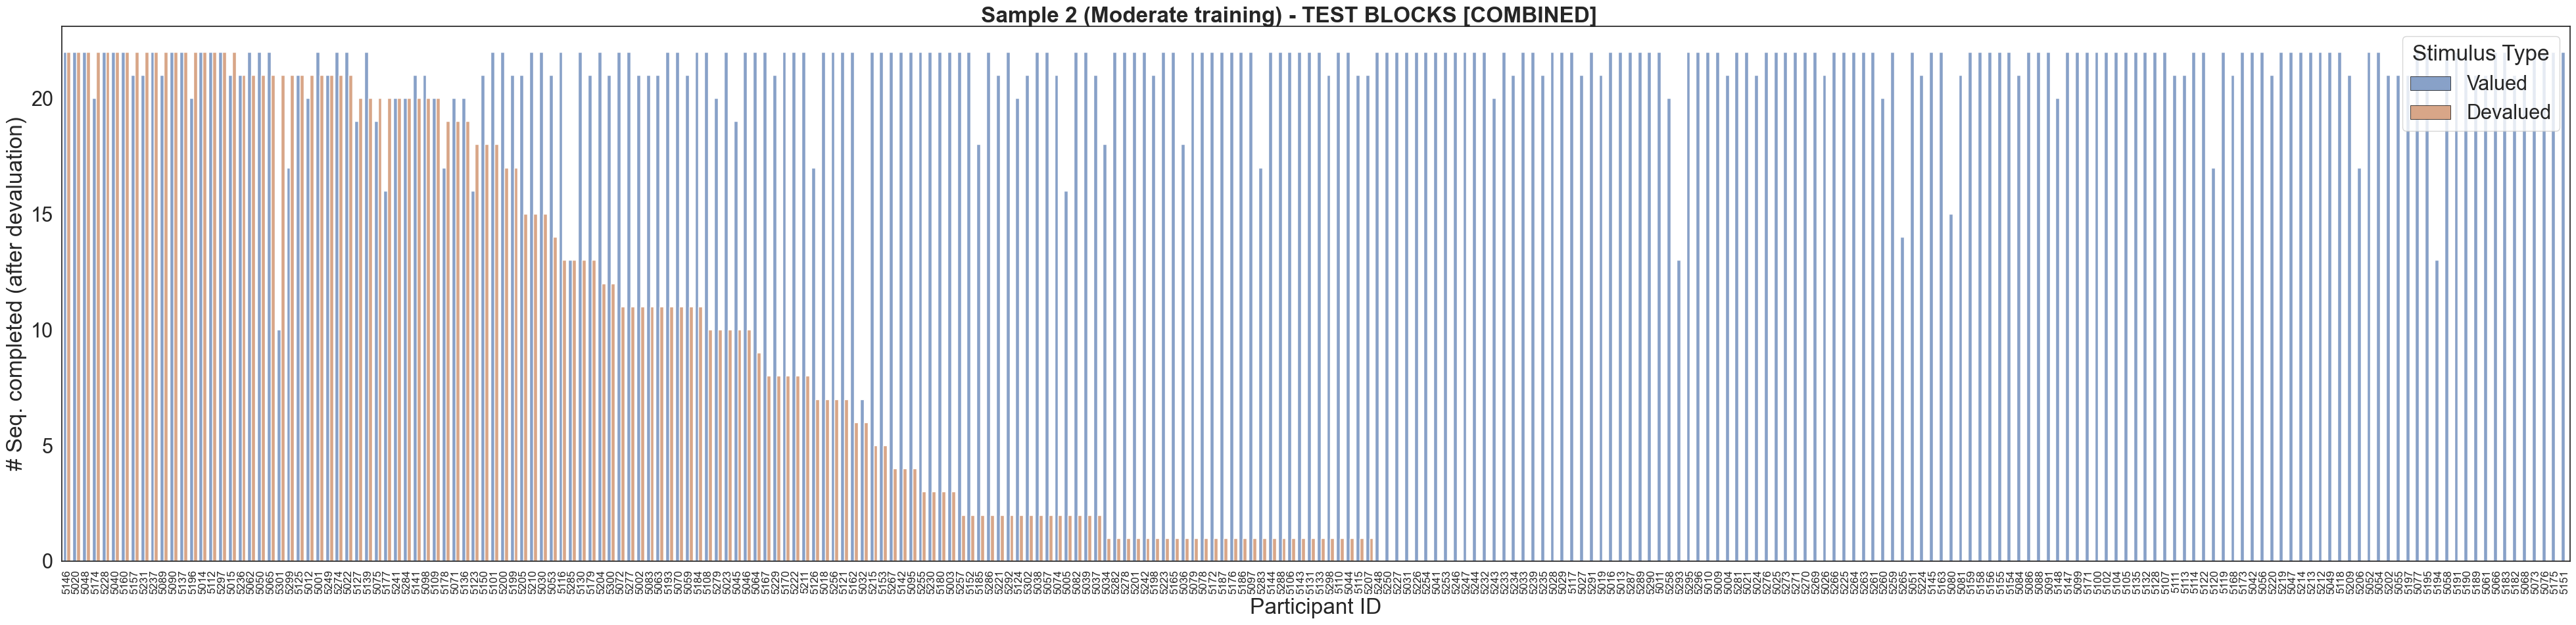

In [75]:
sns.set(font_scale=2)
sns.set_style("white")
# Color palette
fill_palette = {
    'Valued': '#7e9ed2',
    'Devalued': '#e6a37a'
}

# Prepare data
deval_data = main_data_df[main_data_df['phase'].notnull()]
deval_data = deval_data[deval_data['stim_condition'] != 'never_valued']
deval_data['phase'] = deval_data['phase'].astype(str)

deval_data.loc[deval_data['phase'] == 'pre_test','phase'] = 'before'
deval_data.loc[(deval_data['phase'] == 'test') | (deval_data['phase'] == 'reacquisition'),'phase'] = 'after'

# Rename conditions
deval_data['stim_condition'] = deval_data['stim_condition'].replace({
    'still_valued': 'Valued',
    'devalued': 'Devalued'
})

# Summarize
deval_data_summary = deval_data.groupby(['group', 'sub', 'phase', 'stim_condition'])['sequenceCompleted'].sum().reset_index()


fig, ax = plt.subplots(figsize=(40, 10))  # One axis only

group = 'extensive'
data_to_plot = deval_data_summary[
    (deval_data_summary['phase'] == 'after') &
    (deval_data_summary['group'] == group)
]

order = data_to_plot[data_to_plot['stim_condition'] == 'Devalued'].sort_values(
    by='sequenceCompleted', ascending=False
)['sub'].unique()

sns.barplot(
    x='sub',
    y='sequenceCompleted',
    hue='stim_condition',
    hue_order=['Valued', 'Devalued'],
    data=data_to_plot,
    order=order,
    palette=fill_palette,
    ax=ax
)

ax.set_ylabel('# Seq. completed (after devaluation)')
ax.set_xlabel('Participant ID')
ax.tick_params(axis='x', labelrotation=90, labelsize=12)

legend = ax.legend(title='Stimulus Type')
for handle in legend.legendHandles:
    handle.set_edgecolor('black')
    handle.set_linewidth(0.5)

fig.tight_layout(pad=1.5)
fig.suptitle('Sample 2 (Moderate training) - TEST BLOCKS [COMBINED]', fontsize=24, weight='bold')
plt.show()


#### Effects of last devaluation trial (Fig. 2H + stats)

In [76]:
# Work on a copy, sorted (removed 'group' from the selection)
main_data_df_deval_in_after_only = main_data_df.loc[:, [
    'sub', 'block', 'trial', 'choice_rt', 'stim_condition', 'sequenceCompleted',
    'SRO_rt_of_SRO_key', 'SRO_seq_completion_time', 'StayOnKey', 'StayOnLocation',
    'phase', 'time'
]].copy()

# Keep only "after" + devalued trials
main_data_df_deval_in_after_only = main_data_df_deval_in_after_only[
    (main_data_df_deval_in_after_only['time'] == 'after') &
    (main_data_df_deval_in_after_only['stim_condition'] == 'devalued')
].reset_index(drop=True)

# Now I want to add a variable that indicates whether the sequence was completed on the previous trial
main_data_df_deval_in_after_only['previous_deval_sequenceCompleted'] = (
    main_data_df_deval_in_after_only.groupby(['sub', 'block'])['sequenceCompleted']
    .shift(1)
)
# change 0 to "Not responded" and 1 to "Responded":
main_data_df_deval_in_after_only['previous_deval_sequenceCompleted'] = main_data_df_deval_in_after_only['previous_deval_sequenceCompleted'].replace({0: 'Not responded', 1: 'Responded'})
main_data_df_deval_in_after_only['sequenceCompleted'] = main_data_df_deval_in_after_only['sequenceCompleted'].astype(int)

# Send to R
robjects.globalenv['ME_data'] = pandas2ri.py2rpy(main_data_df_deval_in_after_only)

# --- R side: Fit model and create plots in same style ---
r_code = """
library(ggplot2)
library(dplyr)
library(tidyr)

# Run the model with different reference levels for simple effects:

# Factors
ME_data$sub <- factor(ME_data$sub)
ME_data$previous_deval_sequenceCompleted <- factor(ME_data$previous_deval_sequenceCompleted, levels = c("Not responded", "Responded"))

# Run with different reference levels:
# ---------------------------------------------
simple_model <- glmer(sequenceCompleted ~ previous_deval_sequenceCompleted + (1 | sub), data = ME_data, family = binomial, control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5)))
print("SIMPLE MODEL SUMMARY with Not responded as Ref level:")
print(summary(simple_model))

ME_data$previous_deval_sequenceCompleted <- factor(ME_data$previous_deval_sequenceCompleted, levels = c("Responded", "Not responded"))  # Reverse order
# Fit the model again
simple_model <- glmer(sequenceCompleted ~ previous_deval_sequenceCompleted + (1 | sub), data = ME_data, family = binomial, control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5)))
print("SIMPLE MODEL SUMMARY with Responded as Ref level:")
print(summary(simple_model))


# Plot the data:
# -----------------------------
# Compute subject-level averages for this dataset
subject_rates <- ME_data %>%
  filter(!is.na(previous_deval_sequenceCompleted)) %>%   # <--- drop NA trials
  group_by(sub, previous_deval_sequenceCompleted) %>%
  summarise(
    avg_completion = mean(sequenceCompleted, na.rm = TRUE),
    .groups = "drop"
  )

# Plot: boxplots + individual subject dots with single dark green color and narrower width
data_plot <- subject_rates %>%
  ggplot(aes(x = previous_deval_sequenceCompleted, 
             y = avg_completion)) +
  geom_boxplot(alpha = 0.2, outlier.shape = NA, width = 0.3, 
               color = "darkgreen", fill = "darkgreen") +
  geom_jitter(width = 0.14, height = 0, alpha = 0.3, size = 1.5, 
              color = "darkgreen") +
  scale_y_continuous(limits = c(0, 1)) +
  labs(
    x = "Previous response",
    y = "Prop. of habitual responses"
  ) +
  theme_bw() +
  theme(
    strip.text = element_text(size = 14.5, face = "bold"),
    axis.title.x = element_text(size = 18),
    axis.title.y = element_text(size = 18),
    axis.text = element_text(size = 16),
    legend.position = "none"
  )

print(data_plot)

ggsave("PLOT_Observed_completion_boxpoints_STUDY2.png", data_plot,
       width = 6, height = 6, dpi = 300)

       
# Now run the model with effect coding:
contrasts(ME_data$previous_deval_sequenceCompleted) <- contr.sum(2)

simple_model <- glmer(sequenceCompleted ~ previous_deval_sequenceCompleted + (1 | sub), data = ME_data, family = binomial, control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e5)))
print("SIMPLE MODEL SUMMARY with effect coding:")
print(summary(simple_model))
library(car)
print(Anova(simple_model, type = "III"))  # Type III ANOVA for significance testing

"""
robjects.r(r_code)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "previous_deval_sequenceCompleted". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


[1] "SIMPLE MODEL SUMMARY with Not responded as Ref level:"
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: sequenceCompleted ~ previous_deval_sequenceCompleted + (1 | sub)
   Data: ME_data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  1906.2   1925.9   -950.1   1900.2     5157 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9835 -0.0771 -0.0771  0.0926  7.8949 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 8.636    2.939   
Number of obs: 5160, groups:  sub, 258

Fixed effects:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                                -4.1030     0.2929  -14.01   <2e-16
previous_deval_sequenceCompletedResponded   3.5553     0.1759   20.21   <2e-16
                                             
(Intercept)             

#### Sequences completed before and after outcome devluation
#### Fig. 2G

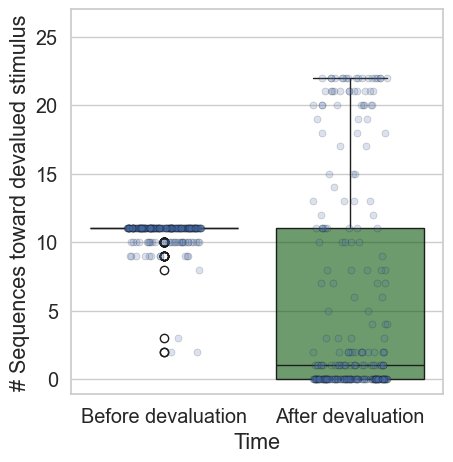

In [77]:
# create a violin plot of the data:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

# a boxplot with stripplot:
# -------------------------------------------
plt.figure(figsize=(4.8, 5))

ax= sns.boxplot(data=deval_data_summary[(deval_data_summary['stim_condition'] == 'Devalued')], x='phase', hue='phase', y='sequenceCompleted', order=['before', 'after'], palette={'before': 'darkgreen', 'after': 'darkgreen'})

plt.xticks([0, 1], ['Before devaluation', 'After devaluation'])

# set y label:
plt.ylabel('# Sequences toward devalued stimulus')
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))

sns.stripplot(data=deval_data_summary[(deval_data_summary['stim_condition'] == 'Devalued')], x='phase', y='sequenceCompleted', order=['before', 'after'], dodge=True, jitter=0.2, alpha=0.2, edgecolor='black', linewidth=0.5)

# Get the current handles and labels
handles, labels = ax.get_legend_handles_labels()

# Remove the last two labels
handles = handles[:-2]
labels = labels[:-2]

plt.xlabel('Time')

plt.ylim(top=27)

plt.show()



## ==========================================
## Automaticity and habit relationship (Fig. 3)
## ==========================================

### IPI Consistency (Fig 3F)

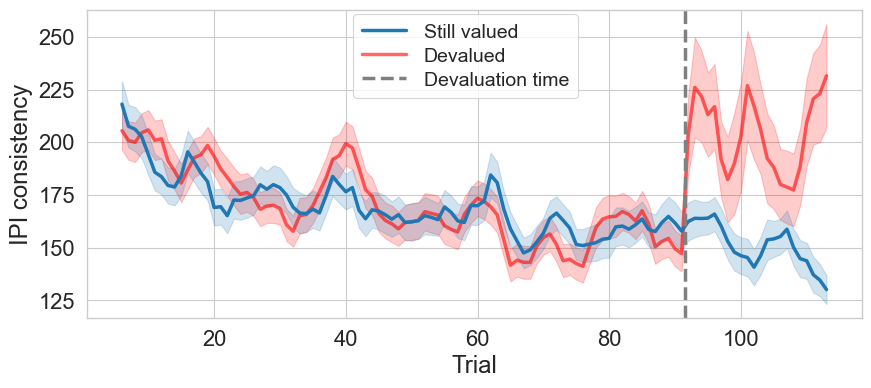

In [78]:

def plotIPIsConsistency(data, var_of_comparison= None, to_smooth=False, smoothing_window=5, combine_groups=False):
    # remove reward type rock:
    data = data[data['rewardType'] != 'rock']

    # -----------------------------------------------------------
    # Prepare the data for plotting:
    # -----------------------------------------------------------
    extensive_data = data[data['group'] == 'extensive']
    extensive_first_deval_trial = extensive_data[extensive_data['activeManipulation'] == 'devaluation'].sort_values(by='stim_abs_trial').iloc[0]['stim_abs_trial']-0.5

    # smooth the data:
    if to_smooth:
        extensive_data['IPI_abs_diff_sum'] = (
            extensive_data.groupby(['sub', 'stim_condition'])['IPI_abs_diff_sum']
            .transform(lambda x: x.rolling(smoothing_window).mean())
        )

    # -----------------------------------------------------------
    # plot the IPI data:
    # -----------------------------------------------------------
    if var_of_comparison:
        palette=[(1, 0, 0, 0.6), '#1f77b4']
    else:
        palette=None

    reconcat_data = pd.concat([extensive_data])

    fig, axe = plt.subplots(1, 1, figsize=(10, 4))

    sns.lineplot(data=reconcat_data, x='stim_abs_trial', y='IPI_abs_diff_sum', hue= var_of_comparison, style='group', palette=palette, ax=axe, errorbar=('se',1))

    axe.axvline(extensive_first_deval_trial, color='gray', label='ET devaluation', linestyle='--', linewidth=2.5)

    # title to the figure:
    if var_of_comparison:
        title = 'IPIs consistency by ' + var_of_comparison
    else:
        title = 'IPIs consistency across all stimuli'

    if to_smooth:
        title += f" (rolling average = {smoothing_window})"
        
    axe.set_xlabel('Trial')
    axe.set_ylabel('IPI consistency')
    # Remove Seaborn's automatic legend that includes titles
    if axe.legend_:
        axe.legend_.remove()

    # Get all handles and labels from the current plot
    handles, labels = axe.get_legend_handles_labels()

    # Create a new flat legend without a title
    custom_labels = {
        'still_valued': 'Still valued',
        'devalued': 'Devalued',
        'ET devaluation': 'Devaluation time'
    }

    # Create mapping of original labels to handles
    label_handle_map = dict(zip(labels, handles))

    # Define desired order of keys
    desired_order = ['still_valued', 'devalued', 'ET devaluation']

    # Build new legend items in desired order
    ordered_handles = []
    ordered_labels = []

    for key in desired_order:
        if key in label_handle_map:
            ordered_handles.append(label_handle_map[key])
            ordered_labels.append(custom_labels[key])

    # Apply custom legend
    if ordered_handles:
        legend = axe.legend(ordered_handles, ordered_labels, loc='center left', bbox_to_anchor=(0.33, 0.85), title=None, labelspacing=0.2)
        for text in legend.texts:
            text.set_fontsize(14)

# ----------------------------------------------------------------------------------------------------------------------
# prepare data and plot:
# ----------------------------------------------------------------------------------------------------------------------

IPI_consistency_data_by_trial = IPI_consistency_data_by_trial.sort_values(by=['sub', 'block', 'trial']).reset_index(drop=True)

sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

plotIPIsConsistency(IPI_consistency_data_by_trial, var_of_comparison='stim_condition', to_smooth=True, smoothing_window=5, combine_groups=True)


### Model training

In [79]:
# add time to the data (IPI_consistency_data_by_trial):
IPI_consistency_data_by_trial.loc[:, 'time'] = IPI_consistency_data_by_trial['phase'].apply(lambda x: 'before' if x == 'pre_test' else np.nan)
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'test', 'time'] = 'after'
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'reacquisition', 'time'] = 'after'

In [80]:
var = 'IPI_abs_diff_sum'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None

sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})


# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial[(IPI_consistency_data_by_trial['rewardType'] != 'rock') & (IPI_consistency_data_by_trial['blockType'] != 'gambles_only') & (IPI_consistency_data_by_trial['time'] != 'after')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    
    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')



/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/3318433333.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.16


In [81]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(IPI_consistency_data_by_trial, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')


### Fig 3G

<>:18: DeprecationWarning: invalid escape sequence '\L'
<>:31: DeprecationWarning: invalid escape sequence '\L'
<>:18: DeprecationWarning: invalid escape sequence '\L'
<>:31: DeprecationWarning: invalid escape sequence '\L'
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/482858355.py:18: DeprecationWarning: invalid escape sequence '\L'
  plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/482858355.py:31: DeprecationWarning: invalid escape sequence '\L'
  plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')


Pearson correlation for end_of_training_pred with devaluation ratio: 0.308, p-value: 0.0000
(258, 10)


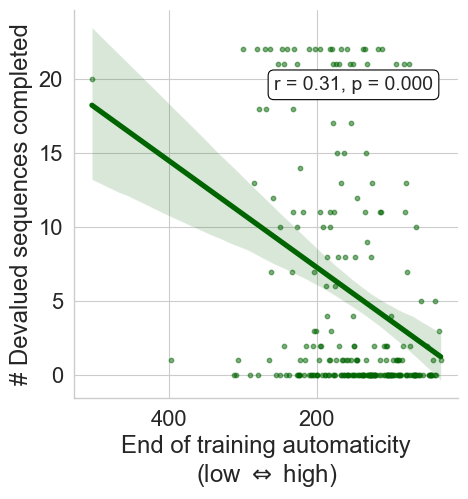

(256, 10)


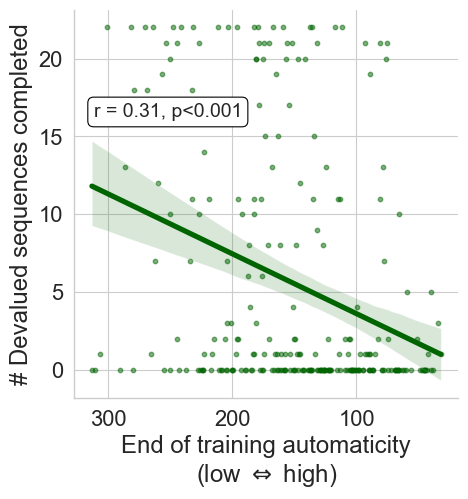

In [82]:


sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
only_after_devalued_data = only_after_devalued_data.assign(end_of_training_pred_neg = -only_after_devalued_data["end_of_training_pred"])
pallette = ['darkgreen']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")
print(only_after_devalued_data.shape)

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training automaticity\n(flipped IPI consistency)')
plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')
plt.gca().invert_xaxis()  # for x-axis
plt.annotate(f"r = {pearson_corr:.2f}, p = {pearson_p:.3f}", xy=(0.52, 0.83), xycoords="axes fraction", fontsize=14, ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.show()


# now without outliers for visualization purposes:
# ---------------------------------------------------------
only_after_devalued_data = only_after_devalued_data[only_after_devalued_data.end_of_training_pred<320]
print(only_after_devalued_data.shape)

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')
plt.annotate(f"r = {pearson_corr:.2f}, p<0.001", xy=(0.05, 0.76), xycoords="axes fraction", fontsize=14, ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.gca().invert_xaxis()  # for x-axis


### stats

In [83]:
only_after_devalued_data.head()

,group,sub,asymp_to,improvement,alpha,end_of_training_pred,relative_improvement_accomplished,r_squared,sequenceCompleted,end_of_training_pred_neg
0,extensive,5001,1.733485e+02,245.991332,0.063348,174.550594,0.995113,3.180707e-01,21.0,-174.550594
1,extensive,5002,3.252570e-08,206.563367,0.005016,134.864292,0.347105,4.341262e-02,11.0,-134.864292
2,extensive,5003,2.008424e+02,108.498063,0.203573,200.842375,1.000000,3.867773e-02,3.0,-200.842375
3,extensive,5004,1.584044e-10,204.166510,0.002441,166.727818,0.183373,6.929094e-02,0.0,-166.727818
4,extensive,5005,1.949538e+02,0.000012,0.000001,194.953776,0.000091,-2.751577e-12,2.0,-194.953776


In [84]:
robjects.globalenv['only_after_devalued_data'] = only_after_devalued_data

r_code = """
library(lme4)
library(lmerTest)
library(car)
library(sjPlot)
only_after_devalued_data$end_of_training_pred <- scale(only_after_devalued_data$end_of_training_pred)
only_after_devalued_data$sequenceCompleted <- scale(only_after_devalued_data$sequenceCompleted)
# effect coding:
model <- lm(sequenceCompleted ~ end_of_training_pred, data = only_after_devalued_data)
print(summary(model))
print(Anova(model, type = "III"))
tab_model(model, show.std = TRUE)
"""

# Execute user-defined R code
result = robjects.r(r_code)
print(result)



Call:
lm(formula = sequenceCompleted ~ end_of_training_pred, data = only_after_devalued_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4759 -0.6309 -0.3543  0.4652  2.2945 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3.130e-16  5.961e-02   0.000        1    
end_of_training_pred 3.065e-01  5.973e-02   5.131 5.73e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9538 on 254 degrees of freedom
Multiple R-squared:  0.09391,	Adjusted R-squared:  0.09035 
F-statistic: 26.33 on 1 and 254 DF,  p-value: 5.73e-07

Anova Table (Type III tests)

Response: sequenceCompleted
                      Sum Sq  Df F value   Pr(>F)    
(Intercept)            0.000   1   0.000        1    
end_of_training_pred  23.948   1  26.327 5.73e-07 ***
Residuals            231.052 254                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



### Habitual and Non-habitual subgroup comparison (Fig 3H)

<>:53: DeprecationWarning: invalid escape sequence '\L'
<>:53: DeprecationWarning: invalid escape sequence '\L'
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/3857133222.py:53: DeprecationWarning: invalid escape sequence '\L'
  ax.set_ylabel('End of training automaticity\n(low $\Leftrightarrow$ high)')


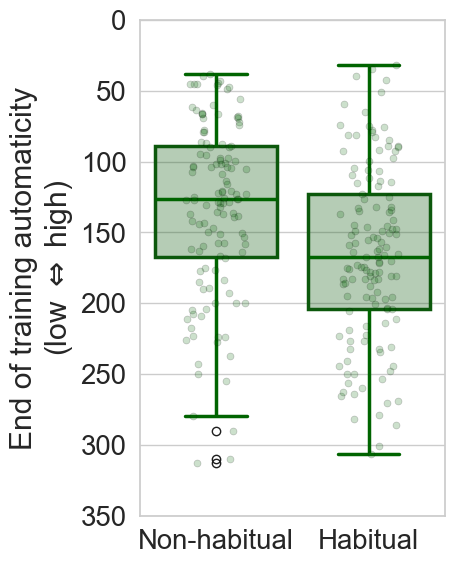

In [85]:
# Set style for paper publication
sns.set(font_scale=1.8)
sns.set_style("whitegrid")

# Create the habitual column
only_after_devalued_data['isHabitual'] = only_after_devalued_data['sequenceCompleted'].apply(
    lambda x: 'Habitual' if x > 0 else 'Non-habitual' if x == 0 else np.nan
)

# Define consistent order
habit_order = ["Non-habitual", "Habitual"]

# --------------------
# Boxplot with stripplot
# --------------------
fig, ax = plt.subplots(figsize=(5, 6))

box_plot = sns.boxplot(
    data=only_after_devalued_data,
    x="isHabitual", 
    y="end_of_training_pred",
    color="darkgreen",
    order=habit_order,
    ax=ax
)

# Semi-transparent boxes with thick darkgreen edges
for patch in box_plot.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.3))
    patch.set_edgecolor((r, g, b))
    patch.set_linewidth(2.5)

# Thicker box lines
for line in ax.lines:
    line.set_linewidth(2.5)
    line.set_color("darkgreen")

# Add individual points 
sns.stripplot(
    data=only_after_devalued_data,
    x="isHabitual",
    y="end_of_training_pred",
    color="darkgreen",
    order=habit_order,
    jitter=0.2,
    alpha=0.2,
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

ax.set_ylabel('End of training automaticity\n(low $\Leftrightarrow$ high)')

ax.set_xlabel("", fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
# plt.ylim(0, 350)
plt.ylim(350, 0)
plt.show()

# Get the data for each group
habitual = only_after_devalued_data[only_after_devalued_data['isHabitual'] == 'Habitual']['end_of_training_pred']
non_habitual = only_after_devalued_data[only_after_devalued_data['isHabitual'] == 'Non-habitual']['end_of_training_pred']

### stats

In [86]:
%%R -i only_after_devalued_data
library(car)
library(sjPlot)

# contrast coding:
only_after_devalued_data$isHabitual <- ifelse(only_after_devalued_data$isHabitual == "Non-habitual", -1, 1)

model <- lm(end_of_training_pred ~ isHabitual, data = only_after_devalued_data)
print(summary(model))
print(Anova(model, type = "III"))
print(tab_model(model, show.std = TRUE))



Call:
lm(formula = end_of_training_pred ~ isHabitual, data = only_after_devalued_data)

Residuals:


     Min       1Q   Median       3Q      Max 
-133.145  -44.138   -4.519   38.087  179.155 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  149.534      3.862  38.717  < 2e-16 ***
isHabitual    15.808      3.862   4.093 5.72e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 61.75 on 254 degrees of freedom
Multiple R-squared:  0.06188,	Adjusted R-squared:  0.05818 
F-statistic: 16.75 on 1 and 254 DF,  p-value: 5.723e-05

Anova Table (Type III tests)

Response: end_of_training_pred
             Sum Sq  Df  F value    Pr(>F)    
(Intercept) 5715519   1 1499.010 < 2.2e-16 ***
isHabitual    63878   1   16.753 5.723e-05 ***
Residuals    968467 254                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### IPI consitency trajectories across sub-groups (Fig. 3I)

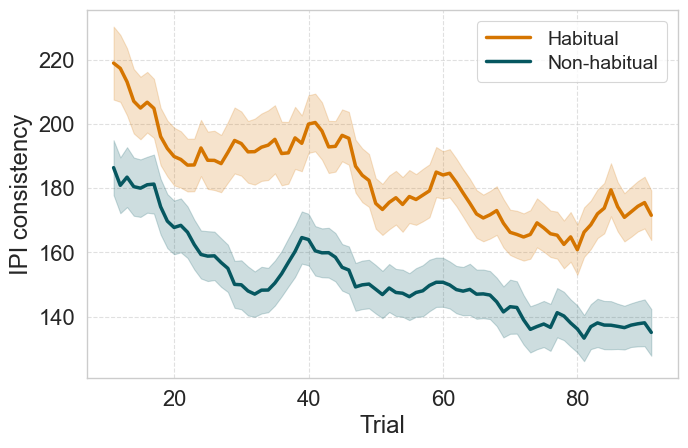

In [87]:
# Style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})
palette = ["darkgreen", "lightgray"]  # Habitual vs Non-habitual
palette=["#D57500", "#065760"]

fig_size_factor = 0.8
fig_size = (9*fig_size_factor, 6*fig_size_factor)

# --- Data prep ---
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial.merge(
    only_after_devalued_data[['sub', 'isHabitual']],
    on='sub',
    how='left'
)

# Remove "after" and "never_valued"
IPI_consistency_data_by_trial_isHabitual = (
    IPI_consistency_data_by_trial_isHabitual[
        IPI_consistency_data_by_trial_isHabitual['time'] != 'after'
    ]
)
IPI_consistency_data_by_trial_isHabitual = (
    IPI_consistency_data_by_trial_isHabitual[
        IPI_consistency_data_by_trial_isHabitual['stim_condition'] != 'never_valued'
    ].reset_index(drop=True)
)

# Sort and add absolute trial counter
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual.sort_values(
    by=['sub', 'block', 'trial']
).reset_index(drop=True)
IPI_consistency_data_by_trial_isHabitual['abs_trial'] = (
    IPI_consistency_data_by_trial_isHabitual.groupby(['sub']).cumcount() + 1
)

# Custom legend labels
custom_labels = {
    'Habitual': 'Habitual',
    'Non-habitual': 'Non-habitual'
}

# smoothing the IPI_abs_diff_sum
IPI_consistency_data_by_trial_isHabitual['smoothed_IPI_abs_diff_sum'] = (
    IPI_consistency_data_by_trial_isHabitual
    .groupby(['sub', 'isHabitual', 'stim_condition'])['IPI_abs_diff_sum']
    .transform(lambda x: x.rolling(window=10).mean())
)
IPI_consistency_data_by_trial_isHabitual = (
    IPI_consistency_data_by_trial_isHabitual
    .groupby(['sub', 'isHabitual', 'stim_abs_trial'])
    .agg({'smoothed_IPI_abs_diff_sum': 'mean'})
    .reset_index()
)

fig, axe = plt.subplots(1, 1, figsize=fig_size)
sns.lineplot(
    data=IPI_consistency_data_by_trial_isHabitual,
    x='stim_abs_trial',
    y='smoothed_IPI_abs_diff_sum',
    hue='isHabitual',
    palette=palette,
    legend='full',
    errorbar=('se', 1),
    ax=axe
)
axe.set_xlabel('Trial')
axe.set_ylabel('IPI consistency')

# Clean legend
handles, labels = axe.get_legend_handles_labels()
unique = []
used = set()
for h, l in zip(handles, labels):
    if l not in used and l in custom_labels:
        unique.append((h, custom_labels[l]))
        used.add(l)
if unique:
    handles_clean, labels_clean = zip(*unique)
    legend = axe.legend(handles_clean, labels_clean, loc='upper right', title=None, labelspacing=0.2)
    for text in legend.texts:
        text.set_fontsize(14)

axe.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### stats

In [88]:
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial.merge( only_after_devalued_data[['sub', 'isHabitual']], on='sub', how='left')

# Remove "after" and "never_valued"
IPI_consistency_data_by_trial_isHabitual = (IPI_consistency_data_by_trial_isHabitual[IPI_consistency_data_by_trial_isHabitual['time'] != 'after'])
IPI_consistency_data_by_trial_isHabitual = (IPI_consistency_data_by_trial_isHabitual[IPI_consistency_data_by_trial_isHabitual['stim_condition'] != 'never_valued'].reset_index(drop=True))

# Sort and add absolute trial counter
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial_isHabitual.sort_values(by=['sub', 'block', 'trial']).reset_index(drop=True)
IPI_consistency_data_by_trial_isHabitual['abs_trial'] = (IPI_consistency_data_by_trial_isHabitual.groupby(['sub']).cumcount() + 1)

IPI_consistency_per_abs_trial = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'stim_abs_trial', 'stim_condition', 'isHabitual']).agg({'IPI_abs_diff_sum': 'mean'}).reset_index()
IPI_consistency_per_abs_trial['stim_abs_trial'] = IPI_consistency_per_abs_trial.groupby(['sub', 'stim_condition']).cumcount() + 1
IPI_consistency_per_abs_trial = IPI_consistency_per_abs_trial.groupby(['sub', 'stim_abs_trial', 'isHabitual']).agg({'IPI_abs_diff_sum': 'mean'}).reset_index()

In [89]:
%%R -i IPI_consistency_per_abs_trial
library(car)
library(lme4)
library(lmerTest)

# Ensure factor coding before applying contrasts:
IPI_consistency_per_abs_trial$isHabitual <- factor(IPI_consistency_per_abs_trial$isHabitual,levels = c("Non-habitual", "Habitual"))
# effect coding:
contrasts(IPI_consistency_per_abs_trial$isHabitual) <- contr.sum(2)
# scale stim_abs_trial:
IPI_consistency_per_abs_trial$stim_abs_trial <- scale(IPI_consistency_per_abs_trial$stim_abs_trial)

model <- lmer(IPI_abs_diff_sum ~ stim_abs_trial*isHabitual + (1|sub), data = IPI_consistency_per_abs_trial)
print(summary(model))
Anova(model, type = "III")

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: IPI_abs_diff_sum ~ stim_abs_trial * isHabitual + (1 | sub)
   Data: IPI_consistency_per_abs_trial

REML criterion at convergence: 291020.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7421 -0.5912 -0.2508  0.2975  9.5571 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept)  3539     59.49  
 Residual             20128    141.87  
Number of obs: 22774, groups:  sub, 256

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                  174.6104     3.8383   253.9896  45.492  < 2e-16
stim_abs_trial               -16.3066     0.9540 22519.5006 -17.093  < 2e-16
isHabitual1                  -18.4780     3.8383   253.9896  -4.814 2.54e-06
stim_abs_trial:isHabitual1     0.7611     0.9540 22519.5006   0.798    0.425
                              
(Intercept)                ***
stim_abs_trial          

## ==========================================
## Effects of devaluation on Automaticity (Fig. 5)
## ==========================================

### Automaticity before vs. after outcome devaluation

#### Fig. 5D

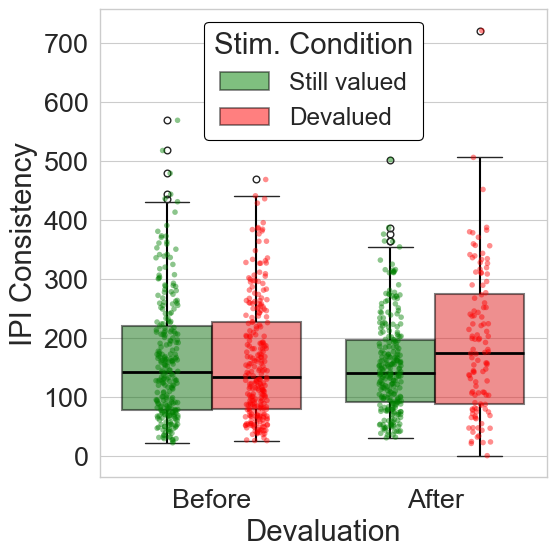

In [90]:
def plotGroupedBoxesSingleGroup_subjectMeans(
    data,
    var_of_interest='IPI_abs_diff_sum',
    time_var='time',
    var_of_comparison='stim_condition',
    subject_var='sub',               
    x_order=['Before', 'After'],
    hue_order=['still_valued', 'devalued'],
    palette_colors={'still_valued': 'green', 'devalued': 'red'},
    y_label='IPI Consistency',
    x_label='Devaluation',
    alpha=0.6,                           
    point_alpha=0.45,                
    point_size=4,
    bbox_to_anchor=(0.95, 0.3),
    figsize=(6, 6)
):

    df = data.copy()
    df = df[df[var_of_comparison].isin(hue_order)]
    df = df.dropna(subset=[var_of_interest])
    df[time_var] = df[time_var].replace({'before': 'Before', 'after': 'After'})
    df[time_var] = pd.Categorical(df[time_var], categories=x_order, ordered=True)

    summary = (df.groupby([subject_var, time_var, var_of_comparison], observed=False)
                 [var_of_interest].mean().reset_index())

    fig, ax = plt.subplots(figsize=figsize)

    # --- boxplots over *subject means* ---
    sns.boxplot(
        data=summary,
        x=time_var,
        y=var_of_interest,
        hue=var_of_comparison,
        order=x_order,
        hue_order=hue_order,
        palette=palette_colors,
        showcaps=True,
        boxprops={'alpha': alpha, 'edgecolor': 'black', 'linewidth': 1.5},
        whiskerprops={'linewidth': 1.5, 'color': 'black'},
        medianprops={'linewidth': 2, 'color': 'black'},
        ax=ax
    )

    # --- Overlay the same subject-mean points ---
    sns.stripplot(
        data=summary,
        x=time_var,
        y=var_of_interest,
        hue=var_of_comparison,
        hue_order=hue_order,
        order=x_order,
        palette=palette_colors,
        dodge=True,
        jitter=True,
        alpha=point_alpha,
        size=point_size,
        ax=ax
    )

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Remove default legend and create custom legend
    ax.get_legend().remove()
    handles = [
        mpatches.Patch(
            facecolor=palette_colors[hue_order[0]],
            edgecolor='black',
            label=hue_order[0].replace('_', ' ').capitalize(),
            linewidth=1.2,
            alpha=alpha
        ),
        mpatches.Patch(
            facecolor=palette_colors[hue_order[1]],
            edgecolor='black',
            label=hue_order[1].replace('_', ' ').capitalize(),
            linewidth=1.2,
            alpha=alpha
        )
    ]
    ax.legend(
        handles=handles,
        title="Stim. Condition",
        loc='upper right',
        bbox_to_anchor=bbox_to_anchor,
        frameon=True,
        framealpha=1,
        edgecolor='black',
        fontsize='small',
        title_fontsize='medium'
    )

    plt.tight_layout()
    plt.show()

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=2.2)

plotGroupedBoxesSingleGroup_subjectMeans(
    data=IPI_consistency_data_by_trial,
    var_of_interest='IPI_abs_diff_sum',
    time_var='time',
    var_of_comparison='stim_condition',
    x_order=['Before', 'After'],
    hue_order=['still_valued', 'devalued'],
    palette_colors={'still_valued': 'green', 'devalued': 'red'},
    y_label='IPI Consistency',
    x_label='Devaluation',
    alpha=0.5,
    bbox_to_anchor=(0.75, 1)
)

#### stats

In [91]:
ME_data = IPI_consistency_data_by_trial[(IPI_consistency_data_by_trial['phase'].notnull()) & (IPI_consistency_data_by_trial['stim_condition'] != 'never_valued')].reset_index(drop=True)
# get only relevant columns:
ME_data = ME_data[['sub', 'phase', 'stim_condition', 'IPI_abs_diff_sum']]
ME_data.loc[:, 'time'] = ME_data['phase'].apply(lambda x: 'before' if x == 'pre_test' else 'after') # ************

# Define the DataFrame in the R global environment
robjects.globalenv['ME_data'] = ME_data

r_code = """
library(lme4)
library(lmerTest)
library(car)
ME_data$time <- as.factor(ME_data$time)
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$stim_condition <- as.factor(ME_data$stim_condition)
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
#scale the DV:
ME_data$IPI_abs_diff_sum <- scale(ME_data$IPI_abs_diff_sum)

model <- lmer(IPI_abs_diff_sum ~ time * stim_condition + (1| sub), data = ME_data)
print(summary(model))

# change reference point:
ME_data$time <- relevel(ME_data$time, ref = "after")
model <- lmer(IPI_abs_diff_sum ~ time * stim_condition + (1| sub), data = ME_data)
print(summary(model))

# change reference point:
ME_data$time <- relevel(ME_data$time, ref = "before")
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "devalued")
model <- lmer(IPI_abs_diff_sum ~ time * stim_condition + (1| sub), data = ME_data)
print(summary(model))

# change reference point:
ME_data$time <- relevel(ME_data$time, ref = "after")
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "devalued")
model <- lmer(IPI_abs_diff_sum ~ time * stim_condition + (1| sub), data = ME_data)
print(summary(model))

# now effect coding:
contrasts(ME_data$stim_condition) <- contr.sum(2)
contrasts(ME_data$time) <- contr.sum(2)
model <- lmer(IPI_abs_diff_sum ~ time * stim_condition + (1| sub), data = ME_data)
print(summary(model))
print(Anova(model, type = "III"))
"""

# Execute user-defined R code
result = robjects.r(r_code)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: IPI_abs_diff_sum ~ time * stim_condition + (1 | sub)
   Data: ME_data

REML criterion at convergence: 33603.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1942 -0.5029 -0.2485  0.0957 11.3511 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09427  0.3070  
 Residual             0.90039  0.9489  
Number of obs: 12122, groups:  sub, 258

Fixed effects:
                                   Estimate Std. Error         df t value
(Intercept)                       7.305e-03  2.641e-02  6.347e+02   0.277
timeafter                        -4.901e-02  2.235e-02  1.188e+04  -2.193
stim_conditiondevalued           -1.639e-02  2.576e-02  1.187e+04  -0.636
timeafter:stim_conditiondevalued  1.355e-01  4.089e-02  1.212e+04   3.315
                                 Pr(>|t|)    
(Intercept)                       0.78217    
timeafter                         0.02

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: IPI_abs_diff_sum ~ time * stim_condition + (1 | sub)
   Data: ME_data

REML criterion at convergence: 33603.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1942 -0.5029 -0.2485  0.0957 11.3511 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.09427  0.3070  
 Residual             0.90039  0.9489  
Number of obs: 12122, groups:  sub, 258

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                       -4.171e-02  2.312e-02  3.753e+02  -1.804
timebefore                         4.901e-02  2.235e-02  1.188e+04   2.193
stim_conditiondevalued             1.192e-01  3.175e-02  1.201e+04   3.753
timebefore:stim_conditiondevalued -1.355e-01  4.089e-02  1.212e+04  -3.315
                                  Pr(>|t|)    
(Intercept)                       0.072012 .  
timebefore                     

### Modeling (with post deval changes)

#### Only (first) test block

In [92]:
# add time to the data (IPI_consistency_data_by_trial):
IPI_consistency_data_by_trial.loc[:, 'time'] = IPI_consistency_data_by_trial['phase'].apply(lambda x: 'before' if x == 'pre_test' else np.nan)
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'test', 'time'] = 'after'
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'reacquisition', 'time'] = 'after'

In [93]:
# NOTE: THIS is with only the the test phase. But results hold when using all test blocks (see below)
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

var = 'IPI_abs_diff_sum'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial[(IPI_consistency_data_by_trial['rewardType'] != 'rock') & (IPI_consistency_data_by_trial['blockType'] != 'gambles_only')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'jump_by', 'transition_steepness', 'relative_improvement_accomplished', 'actual_jump', 'transition_point', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    if sub % 30 == 0:
        print(sub)
    for stim_condition in relevant_trial_data['stim_condition'].unique():
        # prepare sub data:
        # ------------------------
        data = relevant_trial_data[(relevant_trial_data['sub'] == sub) & (relevant_trial_data['stim_condition'] == stim_condition) & (relevant_trial_data['phase'] != 'reacquisition')]
        data = data.copy()
        data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
        data = data[data['smoothed_data'].notna()].reset_index(drop=True)
        # re-create the stim_abs_trial:
        data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()

        x_data = data['stim_abs_trial']
        y_data_smoothed = data['smoothed_data']
        if data[data['time'] == 'after'].shape[0] == 0:
            point_of_first_deval_trial = np.nan
            # Calculate initial guesses from the data:
            y_start = y_data_smoothed.iloc[0]
            y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial-.5)] if not np.isnan(point_of_first_deval_trial-.5) and int(point_of_first_deval_trial-.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
            improvement_guess = abs(y_start - y_end)
            asymp_guess = y_end
            p0 = (asymp_guess, improvement_guess, 0.01)

            popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                                   bounds=([0, 0, 0], [3500, 3500, 1000]))
            y_predicted = exponential_decay(x_data, *popt)
            actual_jump_by = np.nan
        else:
            point_of_first_deval_trial = data[data['time'] == 'after'].sort_values(by='stim_abs_trial').iloc[0]['stim_abs_trial']-0.5
            def exponential_decay_to_quick_growth(x, asymp_to, improvement, alpha, jump_by, transition_steepness):
                decay = asymp_to + improvement * np.exp(-alpha * x)
                switch = 1/(1+np.exp(-transition_steepness*(x-point_of_first_deval_trial)))
                growth = asymp_to + jump_by * switch
                return (1-switch)*decay + switch*growth

            # Calculate initial guesses from the data
            y_start = y_data_smoothed.iloc[0]
            # Use the value at the point of devaluation instead of the last trial
            y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial-.5)] if not np.isnan(point_of_first_deval_trial-.5) and int(point_of_first_deval_trial-.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
            improvement_guess = abs(y_start - y_end)
            asymp_guess = y_end
            # calc jump_by_initial_guess as the difference between after vs. before devaluation:
            jump_by_initial_guess = data.loc[data.time=='after', 'IPI_abs_diff_sum'].mean() - data.loc[data.time=='before', 'IPI_abs_diff_sum'].mean()
            p0 = (asymp_guess, improvement_guess, 0.01, jump_by_initial_guess, 10)
            popt, pcov = curve_fit(exponential_decay_to_quick_growth, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                                   bounds=([0, 0, 0, -3500, 1], [3500, 3500, 1000, 3500, 1000]))
            y_predicted = exponential_decay_to_quick_growth(x_data, *popt)
            # GET the actual jump (according to the current position on the exponent):
            y_at_change_point = exponential_decay_to_quick_growth(point_of_first_deval_trial, *popt)
            actual_jump_by = -1*(popt[3] - (y_at_change_point - popt[0]))

        last_training_point = data[data['time'] != 'after'].iloc[-1]['stim_abs_trial']

        # Calculate the residuals, sum of squares of residuals and the total sum of squares
        residuals = y_data_smoothed - y_predicted
        ss_residuals = np.sum(residuals**2)
        ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
        # calculate the R squared:
        r_squared = 1 - (ss_residuals / ss_total)

        # relative gain of performance ('improvement') by the final point in training (according to the model):
        end_of_training_pred = y_predicted[last_training_point]
        relative_improvement_accomplished = 1 - ((y_predicted[last_training_point] - popt[0]) / popt[1])
 
        results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'jump_by': popt[3] if len(popt) > 3 else np.nan, 'transition_steepness': popt[4] if len(popt) > 4 else np.nan, 'relative_improvement_accomplished': relative_improvement_accomplished, 'actual_jump': actual_jump_by, 'transition_point': point_of_first_deval_trial, 'r_squared': r_squared}, index=[0])])


print(f'mean R^2: {results_df.r_squared.mean().round(3)}')
warnings.resetwarnings()


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/508316605.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'jump_by': popt[3] if len(popt) > 3 else np.nan, 'transition_steepness': popt[4] if len(popt) > 4 else np.nan, 'relative_improvement_accomplished': relative_improvement_accomplished, 'actual_jump': actual_jump_by, 'transition_point': point_of_first_deval_trial, 'r_squared': r_squared}, index=[0])])


5010


5040
5070
5100
5130
5160
5190
5220
5250
mean R^2: 0.177


In [94]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df, on=['sub', 'group', 'stim_condition'], how='left')

##### Fig. 5E

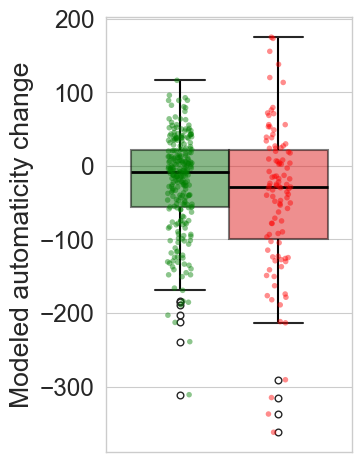

In [95]:
# Set seaborn style
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2})

hue_order   = ['still_valued','devalued']
measure = 'actual_jump'
group_label = 'extensive'
palette = {'still_valued': 'green', 'devalued': 'red'}
alpha = 0.5

# ---------------------------
# Filter Data
# ---------------------------
results_df_plot = results_df[
    (results_df['group'] == group_label) &
    (results_df[measure].notna()) &
    (results_df['stim_condition'].isin(['still_valued', 'devalued']))
]

# ---------------------------
# Boxplot
# ---------------------------
fig, ax = plt.subplots(figsize=(4, 5))
sns.boxplot(
    data=results_df_plot,
    x='group',
    y=measure,
    hue='stim_condition',
    hue_order=hue_order,
    palette=palette,
    linewidth=1.5,
    boxprops={'alpha': alpha, 'edgecolor': 'black', 'linewidth': 1.5},
    whiskerprops={'linewidth': 1.5, 'color': 'black'},
    medianprops={'linewidth': 2, 'color': 'black'},
    ax=ax
)

# --- Overlay the same subject-mean points ---
sns.stripplot(
    data=results_df_plot,
    x='group',
    y=measure,
    hue='stim_condition',
    hue_order=hue_order,
    palette=palette,
    dodge=True,
    jitter=True,
    alpha=0.45,
    size=4,
    ax=ax
)

# Labeling and styling
ax.set_ylabel('Modeled automaticity change')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.legend_.remove()
fig.tight_layout()
plt.show()



##### stats

In [96]:
%%R -i results_df
library(lme4)
library(lmerTest)
library(car)
# remove nans of actual_jump:
ME_data <- results_df[!is.na(results_df$actual_jump), ]
# factor variables:
ME_data$stim_condition <- factor(as.character(ME_data$stim_condition))
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
#scale the actual_jump:
ME_data$actual_jump <- scale(ME_data$actual_jump)

# effect coding:
ME_data$stim_condition <- ifelse(ME_data$stim_condition == "still_valued", -1, 1)
model <- lmer(actual_jump ~ stim_condition + (1| sub), data = ME_data, control = lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 100000)))
print(summary(model))
print(Anova(model, type = "III"))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: actual_jump ~ stim_condition + (1 | sub)
   Data: ME_data
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+05))

REML criterion at convergence: 1021.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1233 -0.4650  0.1801  0.6282  2.7956 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.0000   0.0000  
 Residual             0.9899   0.9949  
Number of obs: 359, groups:  sub, 257

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)  
(Intercept)     -0.05337    0.05805 357.00000  -0.919   0.3585  
stim_condition  -0.12523    0.05805 357.00000  -2.157   0.0316 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
stim_condtn 0.426 
optimizer (bobyqa) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

Analysis of Devi

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '



stim_condition 4.6545  1    0.03097 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


boundary (singular) fit: see help('isSingular')


#### All post devaluation blocks

In [97]:
IPI_consistency_data_by_trial.loc[:, 'time'] = IPI_consistency_data_by_trial['phase'].apply(lambda x: 'before' if x == 'pre_test' else np.nan)
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'test', 'time'] = 'after'
IPI_consistency_data_by_trial.loc[IPI_consistency_data_by_trial.phase == 'reacquisition', 'time'] = 'after'

In [98]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

var = 'IPI_abs_diff_sum'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial[(IPI_consistency_data_by_trial['rewardType'] != 'rock') & (IPI_consistency_data_by_trial['blockType'] != 'gambles_only')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'jump_by', 'transition_steepness', 'relative_improvement_accomplished', 'actual_jump', 'transition_point', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    if sub % 30 == 0:
        print(sub)
    for stim_condition in relevant_trial_data['stim_condition'].unique():
        # prepare sub data:
        # ------------------------
        data = relevant_trial_data[(relevant_trial_data['sub'] == sub) & (relevant_trial_data['stim_condition'] == stim_condition)]
        data = data.copy()
        data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
        data = data[data['smoothed_data'].notna()].reset_index(drop=True)
        # re-create the stim_abs_trial:
        data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()

        x_data = data['stim_abs_trial']
        y_data_smoothed = data['smoothed_data']
        if data[data['time'] == 'after'].shape[0] == 0:
            point_of_first_deval_trial = np.nan
            # Calculate initial guesses from the data:
            y_start = y_data_smoothed.iloc[0]
            y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial-.5)] if not np.isnan(point_of_first_deval_trial-.5) and int(point_of_first_deval_trial-.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
            improvement_guess = abs(y_start - y_end)
            asymp_guess = y_end
            p0 = (asymp_guess, improvement_guess, 0.01)

            popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                                   bounds=([0, 0, 0], [3500, 3500, 1000]))
            y_predicted = exponential_decay(x_data, *popt)
            actual_jump_by = np.nan
        else:
            point_of_first_deval_trial = data[data['time'] == 'after'].sort_values(by='stim_abs_trial').iloc[0]['stim_abs_trial']-0.5
            def exponential_decay_to_quick_growth(x, asymp_to, improvement, alpha, jump_by, transition_steepness):
                decay = asymp_to + improvement * np.exp(-alpha * x)
                switch = 1/(1+np.exp(-transition_steepness*(x-point_of_first_deval_trial)))
                growth = asymp_to + jump_by * switch
                return (1-switch)*decay + switch*growth

            # Calculate initial guesses from the data
            y_start = y_data_smoothed.iloc[0]
            # Use the value at the point of devaluation instead of the last trial
            y_end = y_data_smoothed.iloc[int(point_of_first_deval_trial-.5)] if not np.isnan(point_of_first_deval_trial-.5) and int(point_of_first_deval_trial-.5) < len(y_data_smoothed) else y_data_smoothed.iloc[-1]
            improvement_guess = abs(y_start - y_end)
            asymp_guess = y_end
            # calc jump_by_initial_guess as the difference between after vs. before devaluation:
            jump_by_initial_guess = data.loc[data.time=='after', 'IPI_abs_diff_sum'].mean() - data.loc[data.time=='before', 'IPI_abs_diff_sum'].mean()
            p0 = (asymp_guess, improvement_guess, 0.01, jump_by_initial_guess, 10)
            popt, pcov = curve_fit(exponential_decay_to_quick_growth, x_data, y_data_smoothed, p0=p0, maxfev=100000,
                                   bounds=([0, 0, 0, -3500, 1], [3500, 3500, 1000, 3500, 1000]))
            y_predicted = exponential_decay_to_quick_growth(x_data, *popt)
            # GET the actual jump (according to the current position on the exponent):
            y_at_change_point = exponential_decay_to_quick_growth(point_of_first_deval_trial, *popt)
            actual_jump_by = -1*(popt[3] - (y_at_change_point - popt[0]))
        last_training_point = data[data['time'] != 'after'].iloc[-1]['stim_abs_trial']

        # Calculate the residuals, sum of squares of residuals and the total sum of squares
        residuals = y_data_smoothed - y_predicted
        ss_residuals = np.sum(residuals**2)
        ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
        # calculate the R squared:
        r_squared = 1 - (ss_residuals / ss_total)

        # relative gain of performance ('improvement') by the final point in training (according to the model):
        end_of_training_pred = y_predicted[last_training_point]
        relative_improvement_accomplished = 1 - ((y_predicted[last_training_point] - popt[0]) / popt[1])
        
        results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'jump_by': popt[3] if len(popt) > 3 else np.nan, 'transition_steepness': popt[4] if len(popt) > 4 else np.nan, 'relative_improvement_accomplished': relative_improvement_accomplished, 'actual_jump': actual_jump_by, 'transition_point': point_of_first_deval_trial, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')
warnings.resetwarnings()


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/2008533955.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'jump_by': popt[3] if len(popt) > 3 else np.nan, 'transition_steepness': popt[4] if len(popt) > 4 else np.nan, 'relative_improvement_accomplished': relative_improvement_accomplished, 'actual_jump': actual_jump_by, 'transition_point': point_of_first_deval_trial, 'r_squared': r_squared}, index=[0])])


5010
5040
5070
5100
5130
5160
5190
5220
5250
mean R^2: 0.174


In [99]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df, on=['sub', 'group', 'stim_condition'], how='left')

##### stats

In [100]:
%%R -i results_df
results_df

library(lme4)
library(lmerTest)
library(car)
# remove nans of actual_jump:
ME_data <- results_df[!is.na(results_df$actual_jump), ]
# factor variables:
ME_data$stim_condition <- factor(as.character(ME_data$stim_condition))
ME_data$stim_condition <- relevel(ME_data$stim_condition, ref = "still_valued")
#scale the actual_jump:
ME_data$actual_jump <- scale(ME_data$actual_jump)

# effect coding:
ME_data$stim_condition <- ifelse(ME_data$stim_condition == "still_valued", -1, 1)
model <- lmer(actual_jump ~ stim_condition + (1| sub), data = ME_data)
print(summary(model))
print(Anova(model, type = "III"))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: actual_jump ~ stim_condition + (1 | sub)
   Data: ME_data

REML criterion at convergence: 1060.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8111 -0.5568  0.1532  0.6041  3.0406 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.0000   0.000   
 Residual             0.9821   0.991   
Number of obs: 374, groups:  sub, 258

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)   
(Intercept)     -0.05878    0.05539 372.00000  -1.061  0.28931   
stim_condition  -0.15481    0.05539 372.00000  -2.795  0.00546 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
stim_condtn 0.380 
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: actual_jump
   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


boundary (singular) fit: see help('isSingular')


## ==========================================
## Relationships between habit expression and other automaticity/performance measures (Table S1)
## ==========================================


### -- RT --

#### Model training

In [101]:
var = 'SRO_rt_of_SRO_key'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None


# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']


    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/4292722978.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.366


In [102]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation for end_of_training_pred with devaluation ratio: 0.063, p-value: 0.1584
(258, 9)


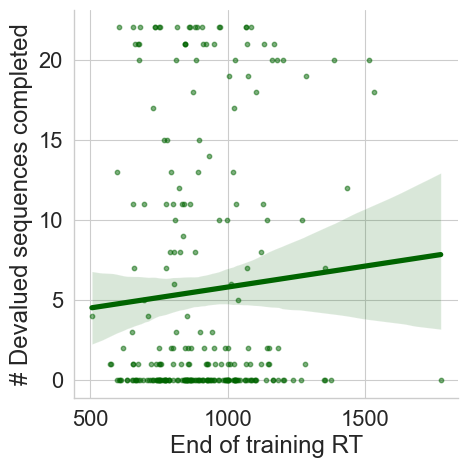

In [103]:


sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['darkgreen']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

print(only_after_devalued_data.shape)
sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training RT')
plt.show()


### -- Sequence Completion Time --

#### Model training

In [104]:
var = 'SRO_seq_completion_time'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None


# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/1995656693.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.481


In [105]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation: 0.251, p-value: 0.000


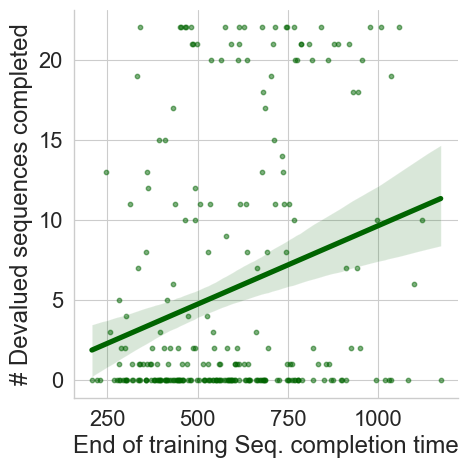

In [106]:

sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['darkgreen']

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training Seq. completion time')

pearson_corr, p_value = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f'Pearson correlation: {pearson_corr:.3f}, p-value: {p_value:.3f}')


### -- Sequence completion time from the START

#### Model training

In [107]:
var = 'SRO_seq_completion_time_from_start'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5 
min_period = None


# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])

print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/2113238723.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.498


In [108]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation: 0.263, p-value: 0.000


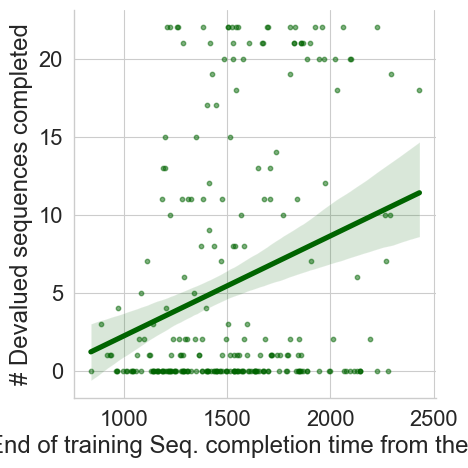

In [109]:


sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['darkgreen']

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training Seq. completion time from the start')

# now pearson:
pearson_corr, p_value = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f'Pearson correlation: {pearson_corr:.3f}, p-value: {p_value:.3f}')

### --- RT STD ---

#### Model training

In [110]:
var = 'SRO_rt_of_SRO_key_local_std'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1 
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
stim_condition = var_of_comparison

relevant_trial_data = prepare_local_std(relevant_trial_data, var_of_comparison=var_of_comparison, var=var, smoothing_window=5)

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/880998783.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.208


In [111]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation for end_of_training_pred with devaluation ratio: 0.264, p-value: 0.0000


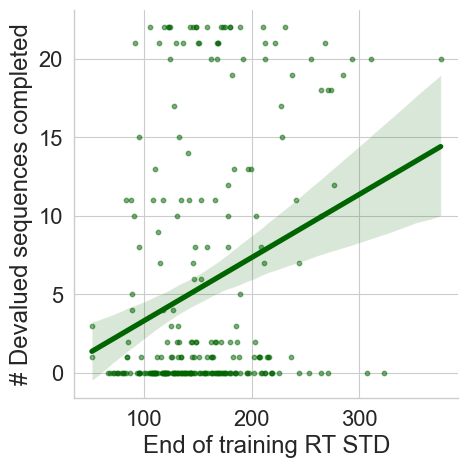

In [112]:


sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['darkgreen']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training RT STD')
plt.show()

### --- Sequence completin time STD ---

#### Model training

In [113]:
var = 'SRO_seq_completion_time_local_std'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1 
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
stim_condition = var_of_comparison

relevant_trial_data = prepare_local_std(relevant_trial_data, var_of_comparison=var_of_comparison, var=var, smoothing_window=5)

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/3036138822.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.132


In [114]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation for end_of_training_pred with devaluation ratio: 0.294, p-value: 0.0000


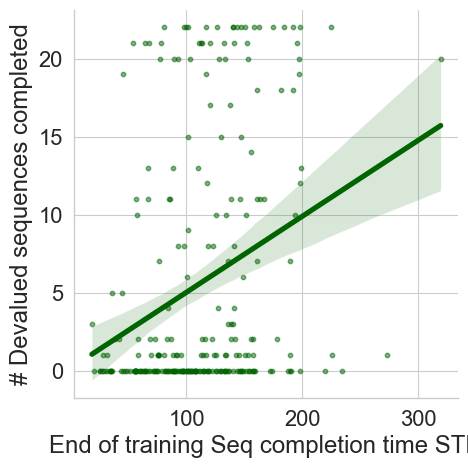

In [115]:


sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['darkgreen']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training Seq completion time STD')
plt.show()

### --- Sequence completin time FROM START STD ---

#### Model training

In [116]:
var = 'SRO_seq_completion_time_from_start_local_std'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1 
min_period = None

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = main_data_df[(main_data_df['rewardType'] != 'rock') & (main_data_df['blockType'] != 'gambles_only') & (main_data_df['time'] != 'after')].copy().reset_index(drop=True)
stim_condition = var_of_comparison

relevant_trial_data = prepare_local_std(relevant_trial_data, var_of_comparison=var_of_comparison, var=var, smoothing_window=5)

# create a dataframe to store the results:
results_df = pd.DataFrame(columns=['sub', 'group', 'stim_condition', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [3500, 3500, 1000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_2341/3800110873.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])


mean R^2: 0.13


In [117]:
# add the data to the main data:
# -------------------------------------------
main_data_df_w_fitting = pd.merge(main_data_df, results_df.drop(columns=['stim_condition']), on=['sub', 'group'], how='left')

##### stats (and visualization)

Pearson correlation for end_of_training_pred with devaluation ratio: 0.250, p-value: 0.0000


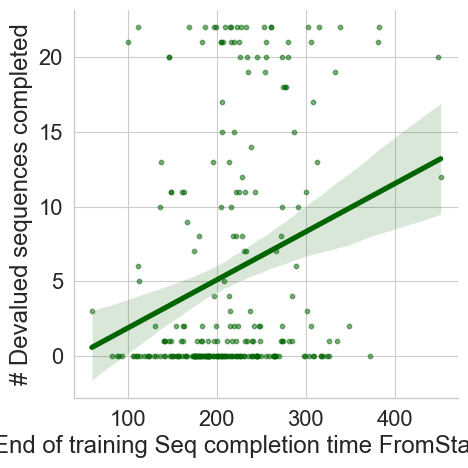

In [118]:


sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting[(main_data_df_w_fitting['time'] == 'after') & (main_data_df_w_fitting['stim_condition'] == 'devalued')].copy()
only_after_devalued_data = only_after_devalued_data.groupby(['group', 'sub', 'asymp_to', 'improvement', 'alpha', 'end_of_training_pred', 'relative_improvement_accomplished', 'r_squared'])['sequenceCompleted'].sum().reset_index()
pallette = ['darkgreen']

pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['sequenceCompleted'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='sequenceCompleted', hue='group', palette=pallette, order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('# Devalued sequences completed')
plt.xlabel('End of training Seq completion time FromStart STD')
plt.show()
